# Домашнее задание "Модели ARIMA"
## Задание
### Выберите ряд из первого задания и постройте его модель ARIMA. Отчет нужно будет оформить в jupyter-ноутбук.
#### Дополнительное задание: попробуйте спрогнозировать график классическим ML.


### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### Импорт данных


In [3]:
# нестационарный ряд
sales_of_company_x = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")

In [4]:
sales_of_company_x.head()

,Month,Count
0,1965-01,154
1,1965-02,96
2,1965-03,73
3,1965-04,49
4,1965-05,36


### Вспомогательные функции

In [5]:
def test_stationarity(timeseries):
    '''Функция выдаёт результаты теста Дика-Фуллера(p-value, статистику, количество лагов, количество точек) на стационарность'''
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [6]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    '''Функция выдаёт результаты теста Дика-Фуллера при помощи функции test_stationarity.
    Проверяет принадлежность объекта указнному классу(в данном случае pd.Series)
    Затем выводит 3 графика: временной ряд, автокорелляция, частитчная автокорелляция перед этим идёт настройка поля отображения'''
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

### Решение

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


C:\Users\first\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


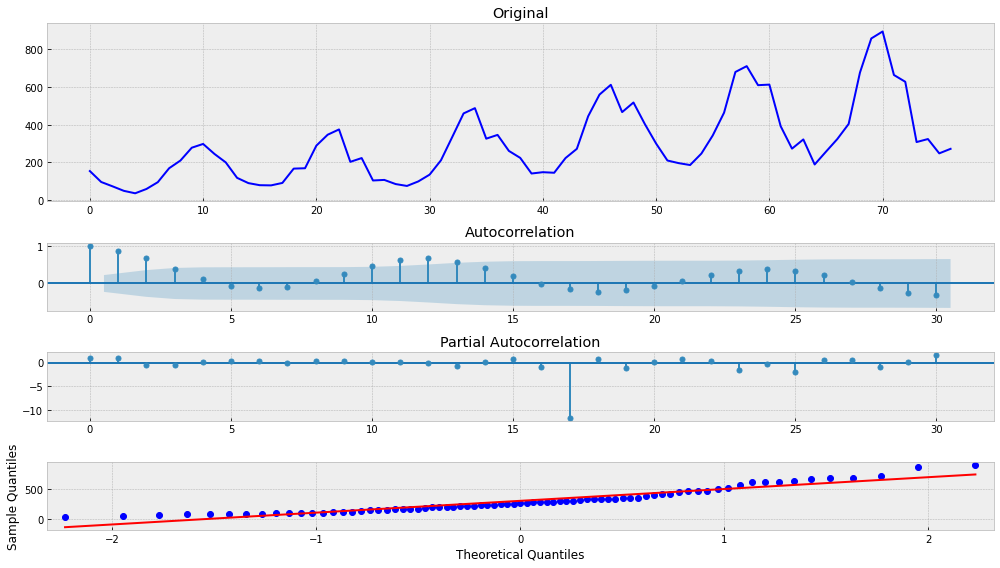

In [7]:
tsplot(sales_of_company_x.Count, lags = 30)

Как мы видим, и тест Дики-Фуллера и графики коррелограмм не отвергают гипотезу о нестационарности ряда. Для начала уберем изменение дисперсии при помощи преобразования Бокса-Кокса

In [8]:
gr_1 = boxcox(sales_of_company_x.Count, 0)

Results of Dickey-Fuller Test:
Test Statistic                 -0.908049
p-value                         0.785310
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


C:\Users\first\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


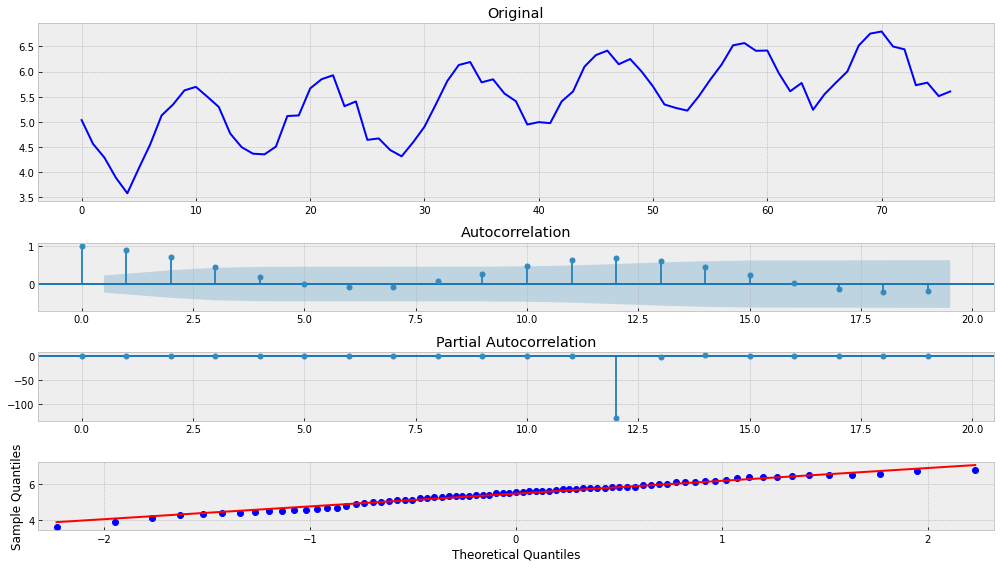

In [9]:
tsplot(gr_1)

Удалось убрать размах дисперсии, но тест Дикки-Фуллера все еще не отвергает гипотезу о нестационарности ряда. По графику ряда видно наличие сильного тренда. Уберем его дифференцированием.

In [10]:
gr_2 = np.diff(gr_1, 1)

Results of Dickey-Fuller Test:
Test Statistic                 -3.135644
p-value                         0.024025
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


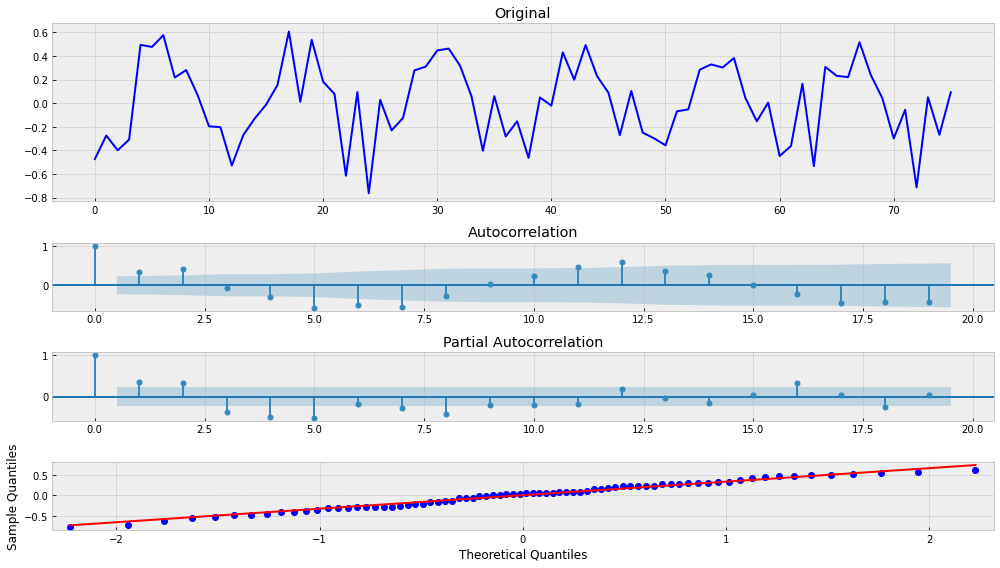

In [11]:
tsplot(gr_2)

Подбор гиперпараметров для модели ARIMA (p, d, q)

C:\Users\first\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\first\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\first\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\first\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\first\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\first\anaconda3\lib\

aic: -33.21456 | order: (3, 0, 2)
Results of Dickey-Fuller Test:
Test Statistic                -9.171934e+00
p-value                        2.375466e-15
#Lags Used                     0.000000e+00
Number of Observations Used    7.500000e+01
Critical Value (1%)           -3.520713e+00
Critical Value (5%)           -2.900925e+00
Critical Value (10%)          -2.587781e+00
dtype: float64


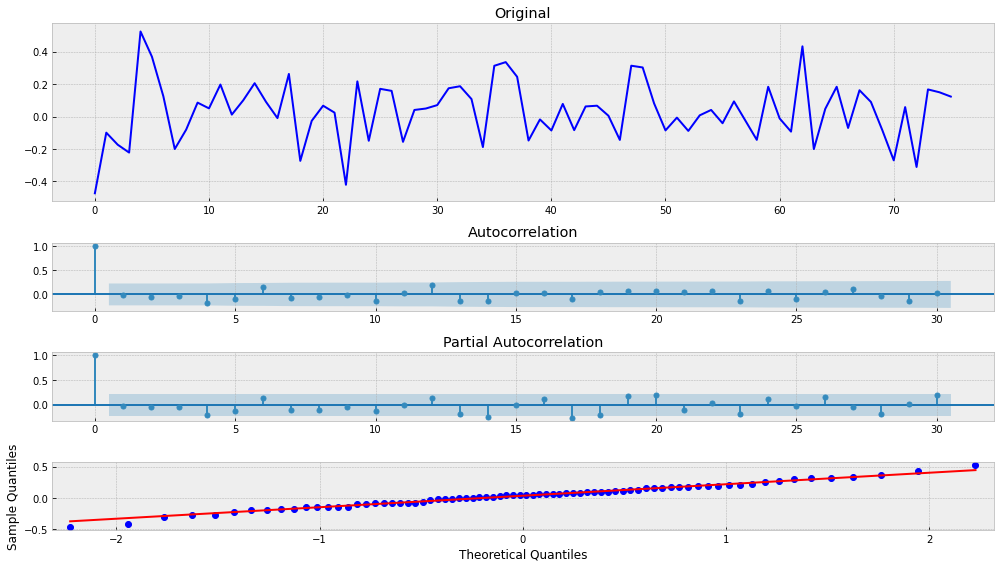

In [12]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(gr_2, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

In [13]:
best_mdl

Построение самого ВР(красный график) и предсказанного временного ряда (синий график) + 95% доверительный интервал.

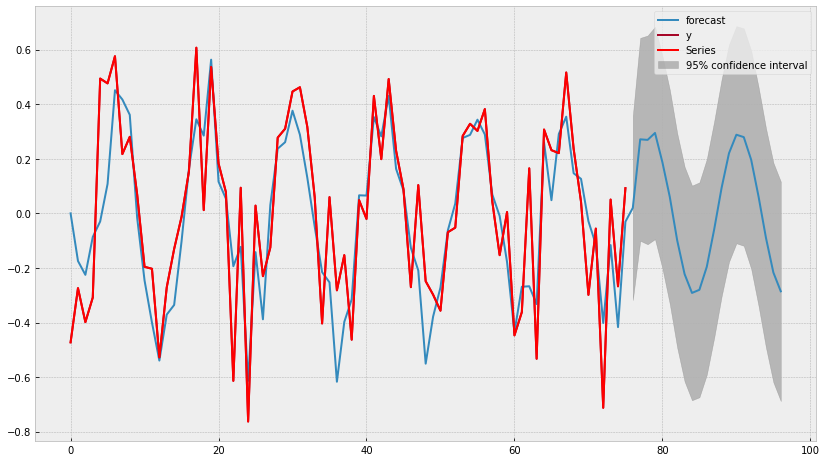

In [14]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(0, len(gr_2)+20, ax=ax)
    plt.plot(gr_2, color='red', label='Series')
    plt.legend()
    plt.show()

### Прогноз методами классического ML

In [15]:
series = sales_of_company_x

In [16]:
len(sales_of_company_x)

77

In [17]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [18]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=0.3)

In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### Модель 1 - Линейная регрессия 

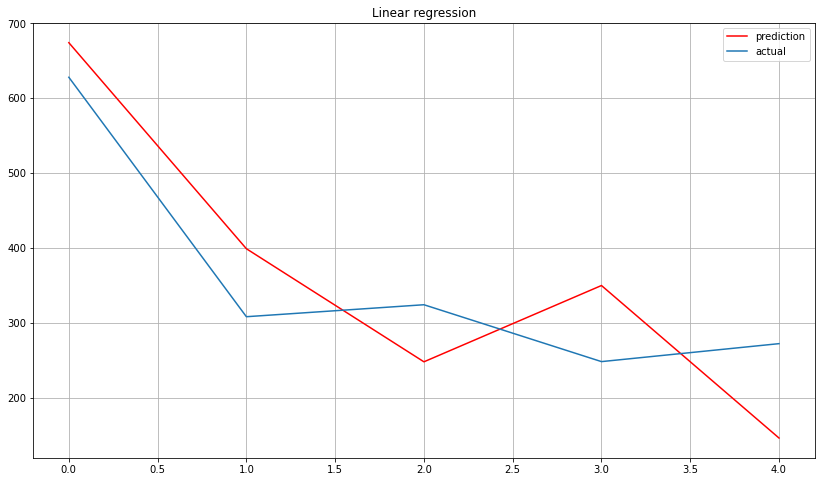

In [20]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

In [21]:
mean_squared_error(y_test, prediction)

8491.60691117759

In [22]:
r2_score(y_test, prediction)

0.5578761813157285

### Модель 2 - Случайный лес

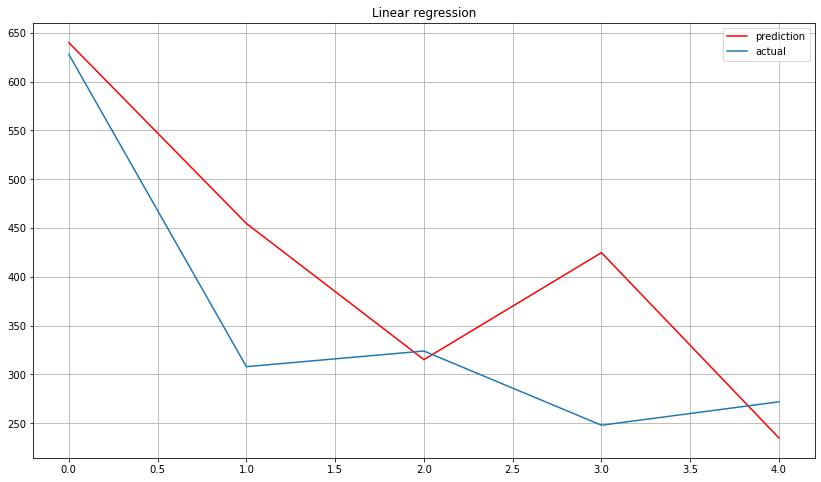

In [27]:
from sklearn.ensemble import RandomForestRegressor

RF = RandomForestRegressor()
RF.fit(X_train, y_train)
prediction = RF.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

In [28]:
mean_squared_error(y_test, prediction)

10874.944780000002

In [29]:
r2_score(y_test, prediction)

0.43378536425358205

По двум графикам и по метрикам: средняя квадратичная ошибка и коэффициент детерминации понятно, что линейная регрессия даёт лучше результат, однако не такой, как модель ARIMA. 